## HRV feature extraction from ECG

In this notebook, we present an exmaple pipeline using existing python packages to process ECG and extract HRV features. The example ECG data used in this repository is based a 5 miniutes recording. 


This tutorial is organised in the following way:
1. [ECG Loading Data](#ecg_data_loading)
2. [ECG Raw Data Visualisation](#ecg_visualisation)
3. [Cleaning ECG and Detecting R-points](#ecg_cleaning_rpoints_detection)
4. [RR Interval Visualisation](#rri_visualisation)
5. [RR Interval Data Cleaning](#rri_cleaning)
6. [HRV Feature Extraction](#hrv_feature_extraction)
    1. [Time Domain Feature Extraction](#time_domain_feature)
    2. [Frequency Domain Feature Extraction](#frequency_domain_feature)
    3. [Non-linear Domain Feature](#non_linear_domain_feature)
    4. [Geometrical Time Domain Feature](#geometrical_time_domain_feature)
    

At the start of the juputer notebook, we will import the relavent python packages. To install Neurokit2 and hrv-analysis package please do 

`pip install hrv-analysis neurokit2`

In [1]:
%matplotlib inline
%matplotlib notebook
import pandas as pd
from matplotlib import style
import matplotlib.pyplot as plt
import hrvanalysis as hrvana # RR interval processing package
import numpy as np
import neurokit2 as nk  # This package can process ECG

In [9]:
plt.style.use('bmh')

<a id="ecg_data_loading"></a>
## Loading ECG Data
Let's load the data to pandas DataFrame.

In [2]:
bio_df = pd.read_csv(r"../example_data/bio_100Hz.txt")

In [3]:
bio_df.head()

,ECG,EDA,Photosensor,RSP
0,-0.015869,13.196868,5.0,0.778931
1,-0.011703,13.197173,5.0,0.777588
2,-0.009766,13.197020,5.0,0.777435
3,-0.013321,13.197631,5.0,0.777557
4,-0.009583,13.196715,5.0,0.775299


<a id="ecg_visualisation"></a>
## ECG Raw Data Visualisation

<IPython.core.display.Javascript object>


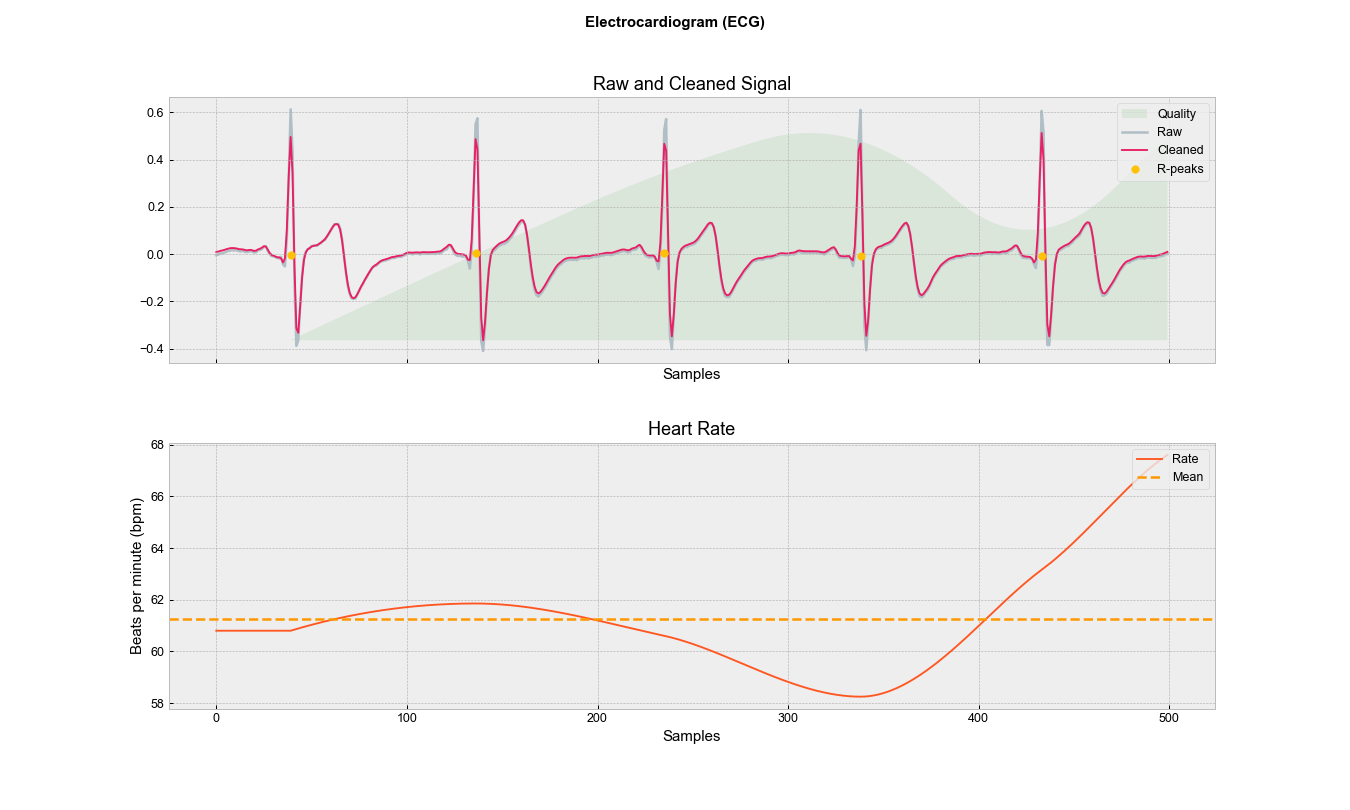

In [10]:
plt.rcParams['figure.figsize'] = [15, 9]
signals, info = nk.ecg_process(bio_df["ECG"].values, sampling_rate=100)

# Visualise the first 5 heart beats. If you want to you plot the entire five minures please remove index selection like plot = nk.ecg_plot(signals)
plot = nk.ecg_plot(signals[10:510])

<a id="ecg_cleaning_rpoints_detection"></a>
## Cleaning ECG and Detecting R-points 

In this case, we use **pantompkins1985** proposed method for cleaning ECG and detecting R-points

In [11]:
cleaned = nk.ecg_clean(bio_df['ECG'], sampling_rate=100, method="pantompkins1985")
pantompkins1985 = nk.ecg_findpeaks(cleaned, method="pantompkins1985")

The **ECG_R_Peaks** column contains the time difference in seconds from each R peak to the **start** of the recording. we will calculate the RR intervals based on the difference between each R points.

In [12]:
hrv_df = pd.DataFrame(pantompkins1985)

In [13]:
hrv_df["RR Intervals"] = hrv_df["ECG_R_Peaks"].diff()
hrv_df.loc[0, "RR Intervals"]=hrv_df.loc[0]['ECG_R_Peaks']

<a id="rri_visualisation"></a>
## RR Interval Visualisation 

Let's have a look the raw RR intervals

<IPython.core.display.Javascript object>


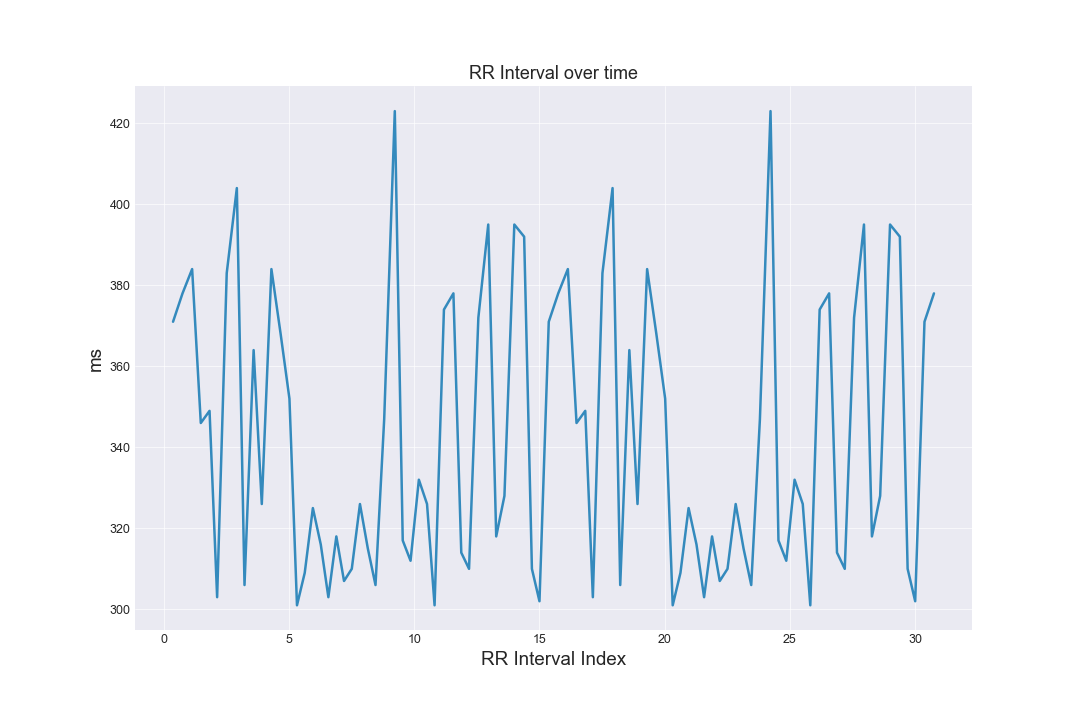

Text(0.5, 0, 'RR Interval Index')

In [15]:
hrvana.plot_timeseries(hrv_df["RR Intervals"].values.tolist()[10:100]) # visualise 90 RR intervals
plt.title("RR Interval over time")
plt.ylabel("ms")
plt.xlabel("RR Interval Index")

<a id="rri_cleaning"></a>
## RR Interval Data Cleaning
To cleaning HRV data, we do the following steps:
1. Removing outliters, we accept the valid RR interval between 300ms to 2000ms.
2. Interpolating removed Nan with forward linear interpolation (values calculated using future RR intervals. We ignored the index and treat the values as equally spaced.  more details please see: [Pandas Interpolation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html) [HRV-Analysis Interpolation](https://github.com/Aura-healthcare/hrvanalysis/blob/master/hrvanalysis/preprocessing.py))
3. Using method proposed by Malik M et al. [Heart Rate Variability](https://doi.org/10.1111/j.1542-474X.1996.tb00275.x) to remove ectopic beats
4. Interpolating removed Nan with forward linear interpolation 


In [16]:
clean_rri = hrv_df['RR Intervals'].values
clean_rri = hrvana.remove_outliers(rr_intervals=clean_rri, low_rri=300, high_rri=2000)
clean_rri = hrvana.interpolate_nan_values(rr_intervals=clean_rri, interpolation_method="linear")
clean_rri = hrvana.remove_ectopic_beats(rr_intervals=clean_rri, method="malik")
clean_rri = hrvana.interpolate_nan_values(rr_intervals=clean_rri, interpolation_method="linear") # default is linear

0 outlier(s) have been deleted.
139 ectopic beat(s) have been deleted with malik rule.


Now the processed let's visualise the processed NN intervals

<IPython.core.display.Javascript object>


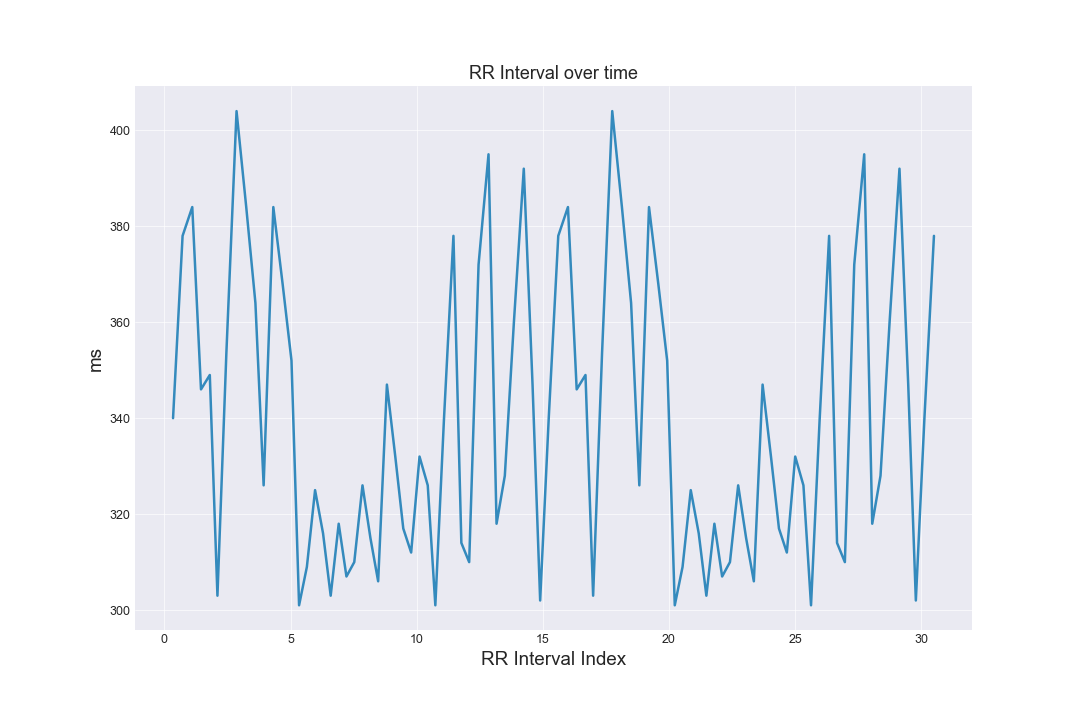

Text(0.5, 0, 'RR Interval Index')

In [17]:
hrvana.plot_timeseries(clean_rri[10:100]) # due to the size of the dataset, here we only show the 90 nnis
plt.title("Cleaned RR intervals")
plt.title("RR Interval over time")
plt.ylabel("ms")
plt.xlabel("RR Interval Index")

In [36]:
hrv_df["RR Intervals"] = clean_rri 
hrv_df["RR Intervals"].isna().any()

False

#### The cleaned RR intervals  become to NN intervals

<a id="hrv_feature_extraction"></a>
## HRV Feature Extraction
The following code will show you how to extract HRV features from 5 minutes NN intervals

In [18]:
nn_epoch = hrv_df['RR Intervals'].values

In [19]:
nn_epoch.shape

(880,)

<a id="time_domain_feature"></a>
### Extract Time Domain Features
- **mean_nni**: The mean of NN-intervals.
- **sdnn** : The standard deviation of the time interval between successive normal heart beats (i.e. the NN-intervals).
- **sdsd**: The standard deviation of differences between adjacent NN-intervals
- **rmssd**: The square root of the mean of the sum of the squares of differences between adjacent NN-intervals. Reflects high frequency (fast or parasympathetic) influences on HRV (*i.e.*, those influencing larger changes from one beat to the next).
- **median_nni**: Median Absolute values of the successive differences between the NN-intervals.
- **nni_50**: Number of interval differences of successive NN-intervals greater than 50 ms.
- **pnni_50**: The proportion derived by dividing nni_50 (The number of interval differences of successive NN-intervals greater than 50 ms) by the total number of NN-intervals. (%)
- **nni_20**: Number of interval differences of successive NN-intervals greater than 20 ms.
- **pnni_20**: The proportion derived by dividing nni_20 (The number of interval differences of successive NN-intervals greater than 20 ms) by the total number of NN-intervals. (%)
- **range_nni**: Difference between the maximum and minimum NN_interval.
- **cvsd**: Coefficient of variation of successive differences equal to the rmssd divided by mean_nni.
- **cvnni**: Coefficient of variation equal to the ratio of sdnn divided by mean_nni.
- **mean_hr**: The mean Heart Rate.
- **max_hr**: Max heart rate.
- **min_hr**: Min heart rate.
- **std_hr**: Standard deviation of heart rate.

Note: we measure NN Intervals in ms

In [20]:
hrvana.get_time_domain_features(nn_epoch)

{'mean_nni': 340.6125,
 'sdnn': 34.55244258219532,
 'sdsd': 44.734739644325586,
 'nni_50': 277,
 'pnni_50': 31.477272727272727,
 'nni_20': 417,
 'pnni_20': 47.38636363636363,
 'rmssd': 44.73481463581322,
 'median_nni': 326.0,
 'range_nni': 122.0,
 'cvsd': 0.13133638558717964,
 'cvnni': 0.1014420861894244,
 'mean_hr': 177.88898440104293,
 'max_hr': 199.33554817275748,
 'min_hr': 141.84397163120568,
 'std_hr': 17.17109661963662}

<a id="frequency_domain_feature"></a>
### Extract Frequence Domain Features
- **total_power** : Total spectral power of all NN intervals (LF + HF + VLF)
- **vlf** : Variance ( = power ) in HRV in the Very low Frequency (.003 to .04 Hz by default). Reflect an intrinsic rhythm produced by the heart which is modulated primarily by sympathetic activity.
- **lf** : Variance ( = power ) in HRV in the low Frequency (.04 to .15 Hz). Reflects a mixture of sympathetic and parasympathetic activity, but in long-term recordings, it reflects sympathetic activity and can be reduced by the beta-adrenergic antagonist propanolol.
- **hf**: Variance ( = power ) in HRV in the High Frequency (.15 to .40 Hz by default). Reflects fast changes in beat-to-beat variability due to parasympathetic (vagal) activity. Sometimes called the respiratory band because it corresponds to HRV changes related to the respiratory cycle and can be increased by slow, deep breathing (about 6 or 7 breaths per minute) and decreased by anticholinergic drugs or vagal blockade.
- **lf_hf_ratio** : lf/hf ratio is sometimes used by some investigators as a quantitative mirror of the sympatho/vagal balance.
- **lfnu** : Normalized lf power. Units: normalized units = $LF/(total power−VLF)×100$
- **hfnu** : Normalized hf power. Units: normalized units = $HF/(total power−VLF)×100$

Note: Spectral power is measured in $msec^2$ 

<IPython.core.display.Javascript object>


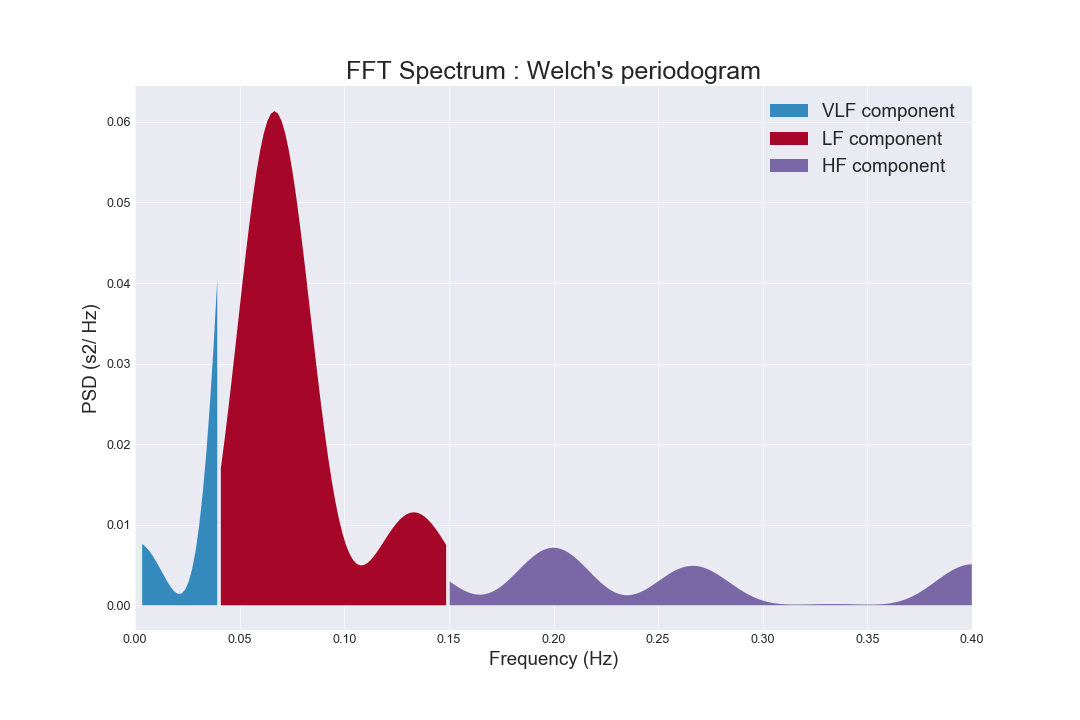

<IPython.core.display.Javascript object>


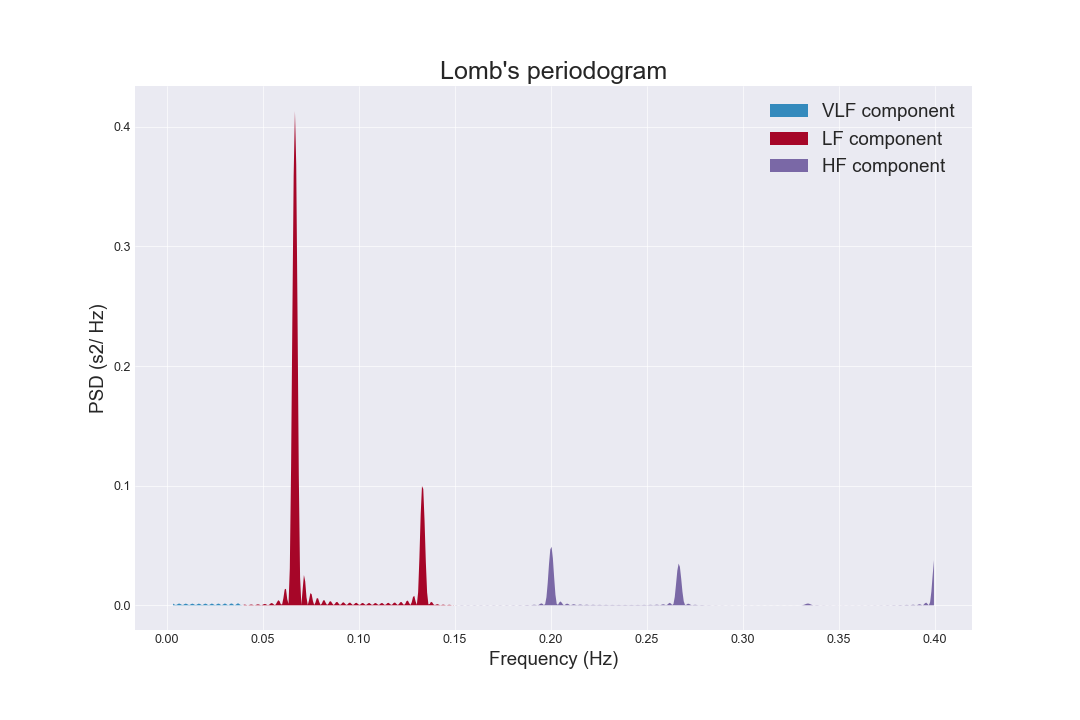

In [21]:
hrvana.plot_psd(nn_epoch)
hrvana.plot_psd(nn_epoch, method="lomb")

In [42]:
hrvana.get_frequency_domain_features(nn_epoch)

{'lf': 268.6184674138709,
 'hf': 68.50110581154146,
 'lf_hf_ratio': 3.9213741768328143,
 'lfnu': 79.68047207815526,
 'hfnu': 20.31952792184473,
 'total_power': 347.08152369405184,
 'vlf': 9.961950468639461}

<a id="non_linear_domain_feature"></a>
### Extract Features from Poincaré plot (Non-linear Domain)
Note: Known practise is to use this function on short term recordings, from 5 minutes window.

<IPython.core.display.Javascript object>


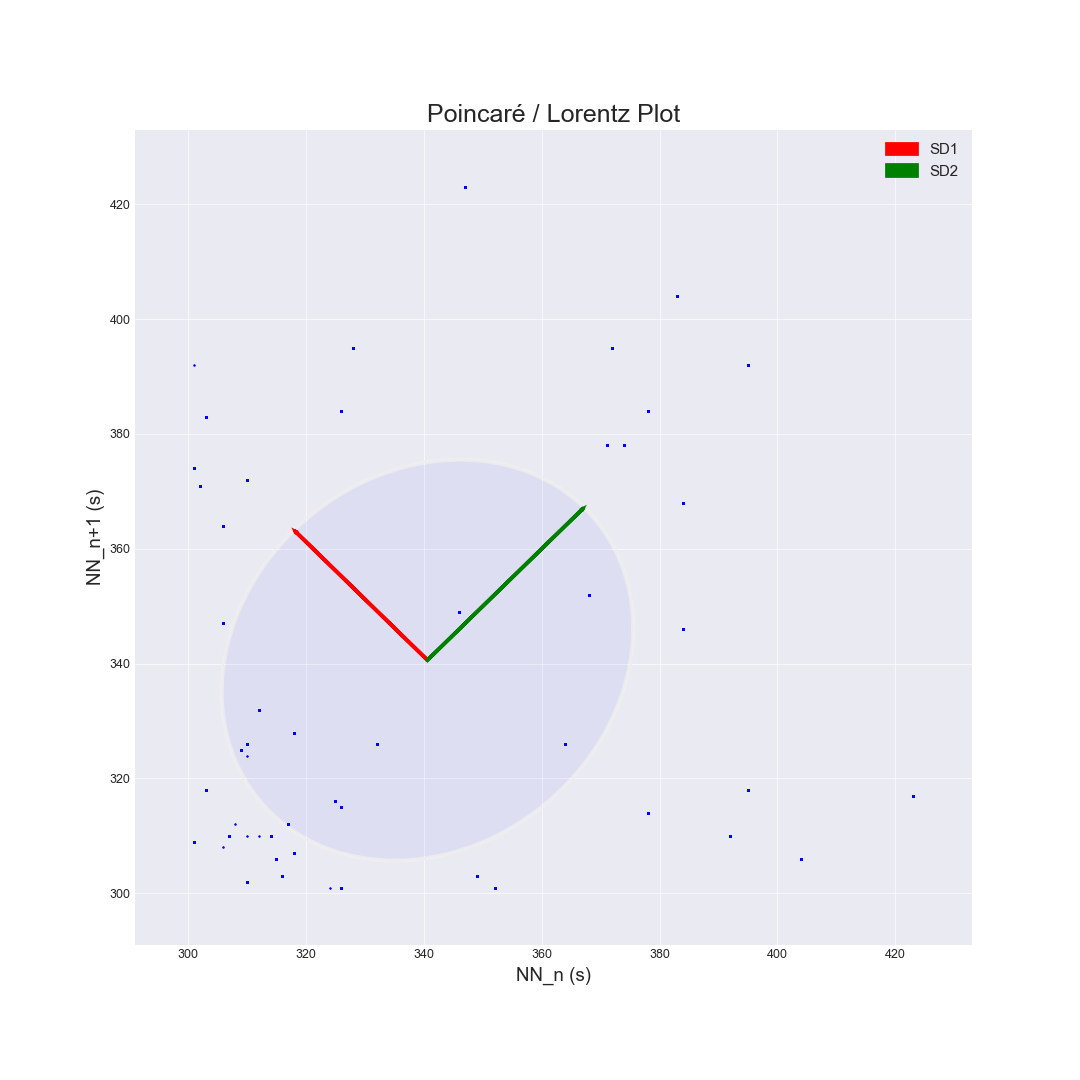

In [22]:
hrvana.plot_poincare(nn_epoch)

In [23]:
hrvana.get_poincare_plot_features(nn_epoch)

{'sd1': 31.650246433644224,
 'sd2': 37.229081072212885,
 'ratio_sd2_sd1': 1.1762651248313303}

<a id="non_linear_domain_feature"></a>
### Extract Additional Non-linear Domain Features 
These features includes CVI (cardiovagal index), CSI (cardiosympathetic index) and Modified CSI(is an alternative measure in research of [seizure detection](https://doi.org/10.1109/embc.2014.6944639)). 


In [24]:
hrvana.get_csi_cvi_features(nn_epoch)

{'csi': 1.1762651248313303,
 'cvi': 4.275379395137752,
 'Modified_csi': 175.16507877904883}

<a id="geometrical_time_domain_feature"></a>
### Extract Geometrical Time Domain Features 
The known practise is to use these features on recordings from 20 minutes to 24 Hours window. We should discard the triangular interpolation of NN-interval histogram (TINN)

In [25]:
hrvana.get_geometrical_features(nn_epoch)

{'triangular_index': 5.432098765432099, 'tinn': None}

The next step is to extract all HRV features and put them in a dataframe

In [26]:
feature_list = []
all_hr_features = {}
all_hr_features.update(hrvana.get_time_domain_features(nn_epoch))
all_hr_features.update(hrvana.get_frequency_domain_features(nn_epoch))
all_hr_features.update(hrvana.get_poincare_plot_features(nn_epoch))
all_hr_features.update(hrvana.get_csi_cvi_features(nn_epoch))
all_hr_features.update(hrvana.get_geometrical_features(nn_epoch))
feature_list.append(all_hr_features)
hrv_feature_df = pd.DataFrame(feature_list)

#### Now you have the *hrv_feature_df* let's show them all together

In [28]:
hrv_feature_df.head()

,mean_nni,sdnn,sdsd,nni_50,pnni_50,nni_20,pnni_20,rmssd,median_nni,range_nni,...,hfnu,total_power,vlf,sd1,sd2,ratio_sd2_sd1,csi,cvi,Modified_csi,triangular_index
0,340.6125,34.552443,44.73474,277,31.477273,417,47.386364,44.734815,326.0,122.0,...,34.388605,275.139715,6.95927,31.650246,37.229081,1.176265,1.176265,4.275379,175.165079,5.432099


In [27]:
if 'tinn' in hrv_feature_df.columns:
    del hrv_feature_df['tinn']

print("Here are the 30 HRV features")
hrv_feature_df.to_dict()

Here are the 30 HRV features


{'mean_nni': {0: 340.6125},
 'sdnn': {0: 34.55244258219532},
 'sdsd': {0: 44.734739644325586},
 'nni_50': {0: 277},
 'pnni_50': {0: 31.477272727272727},
 'nni_20': {0: 417},
 'pnni_20': {0: 47.38636363636363},
 'rmssd': {0: 44.73481463581322},
 'median_nni': {0: 326.0},
 'range_nni': {0: 122.0},
 'cvsd': {0: 0.13133638558717964},
 'cvnni': {0: 0.1014420861894244},
 'mean_hr': {0: 177.88898440104293},
 'max_hr': {0: 199.33554817275748},
 'min_hr': {0: 141.84397163120568},
 'std_hr': {0: 17.17109661963662},
 'lf': {0: 175.95693246191382},
 'hf': {0: 92.2235130551881},
 'lf_hf_ratio': {0: 1.907940032132784},
 'lfnu': {0: 65.61139538814473},
 'hfnu': {0: 34.388604611855264},
 'total_power': {0: 275.13971547806636},
 'vlf': {0: 6.959269960964425},
 'sd1': {0: 31.650246433644224},
 'sd2': {0: 37.229081072212885},
 'ratio_sd2_sd1': {0: 1.1762651248313303},
 'csi': {0: 1.1762651248313303},
 'cvi': {0: 4.275379395137752},
 'Modified_csi': {0: 175.16507877904883},
 'triangular_index': {0: 5.4320